## Preprocessing

In [7]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import tqdm
from timeit import default_timer as timer

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate

In [8]:
os.chdir('c:/users/fre_f/pythonprojects/bacteriological/')

In [9]:
df = pd.read_csv('./data/final/04_genus_desl_ra.csv')

In [10]:
df.head()

,Index,DESL,Corynebacterium,Staphylococcus,Propionibacterium,sp50014,Moraxella,Blautia,sp50017,sp5276,...,Light treatment,OSDI score,DEQ5 score,TBUT OD,TBUT OS,OSS OD,OSS OS,ST OD,ST OS,Demodicosis
0,P1,3,0.092816,0.001058,0.042075,0.0,0.0,0.000000,0.0,0.000000,...,0,NaN,NaN,3,3,0,0,23,23,0
1,P2,3,0.698862,0.001191,0.004366,0.0,0.0,0.000000,0.0,0.000000,...,0,31.25,17.0,2,4,1,3,14,18,0
2,P3,2,0.034017,0.259365,0.003640,0.0,0.0,0.000000,0.0,0.000000,...,1,33.30,16.0,8,8,3,3,11,8,0
3,P4,3,0.029042,0.177362,0.015877,0.0,0.0,0.127216,0.0,0.000000,...,0,93.75,21.0,3,2,2,2,12,11,0
4,P5,1,0.307662,0.164086,0.050351,0.0,0.0,0.000331,0.0,0.000463,...,1,6.25,7.0,11,11,0,0,22,32,0


In [11]:
df.iloc[:,2:600]

,Corynebacterium,Staphylococcus,Propionibacterium,sp50014,Moraxella,Blautia,sp50017,sp5276,Finegoldia,Acinetobacter,...,Dyella,Actinopolymorpha,Trichococcus,melongena,Methylophilus,Murdochiella,Intrasporangium,sp10518,sp44151,Limnobacter
0,0.092816,0.001058,0.042075,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.006020,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
1,0.698862,0.001191,0.004366,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
2,0.034017,0.259365,0.003640,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
3,0.029042,0.177362,0.015877,0.000000,0.0,0.127216,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
4,0.307662,0.164086,0.050351,0.000000,0.0,0.000331,0.0,0.000463,0.0,0.002183,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.358462,0.185519,0.108214,0.016877,0.0,0.000397,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
57,0.077600,0.355253,0.048227,0.000000,0.0,0.006814,0.0,0.036518,0.0,0.001125,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
58,0.296309,0.601019,0.004895,0.000000,0.0,0.004631,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
59,0.834877,0.046375,0.005028,0.000000,0.0,0.008997,0.0,0.004829,0.0,0.006285,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0


In [12]:
df.iloc[:,1]

0     3
1     3
2     2
3     3
4     1
     ..
56    3
57    2
58    2
59    2
60    3
Name: DESL, Length: 61, dtype: int64

In [13]:
X = df.iloc[:,2:600]
y = df.iloc[:,1]

## Cross validate with leave one out and explain according to average of estimators

### XGBoost

In [14]:
le = LabelEncoder()
y_xgb = le.fit_transform(y)


clfxgb = XGBClassifier(random_state=42)
looxgb = LeaveOneOut()
xgb_scores = cross_validate(clfxgb, X, y_xgb, cv=looxgb, scoring='accuracy', return_estimator=True)


In [ ]:
xgb_scores

In [ ]:
feature_importances_complete = []

for idx, estimator in enumerate(xgb_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances)
    feature_importances_complete.append(feature_importances)

feature_importances_complete = pd.concat(feature_importances_complete)

In [17]:
feature_importances_complete

,Importance
Variovorax,0.098368
BurkholderiaParaburkholderia,0.051287
sp35665,0.048631
Cloacibacterium,0.047529
sp30425,0.042475
...,...
Aureimonas,0.000000
Jatrophihabitans,0.000000
Lysinibacillus,0.000000
sp35669,0.000000


In [18]:
feature_importances_complete.shape

(36478, 1)

In [19]:
fic = feature_importances_complete.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [20]:
fic[:15]

,Importance
Variovorax,0.074605
Cloacibacterium,0.051026
Comamonas,0.041495
sp30425,0.040010
Aerococcus,0.039681
Nitriliruptor,0.034739
BurkholderiaParaburkholderia,0.031745
Bradyrhizobium,0.031368
Lactococcus,0.030195
Microbacterium,0.029873


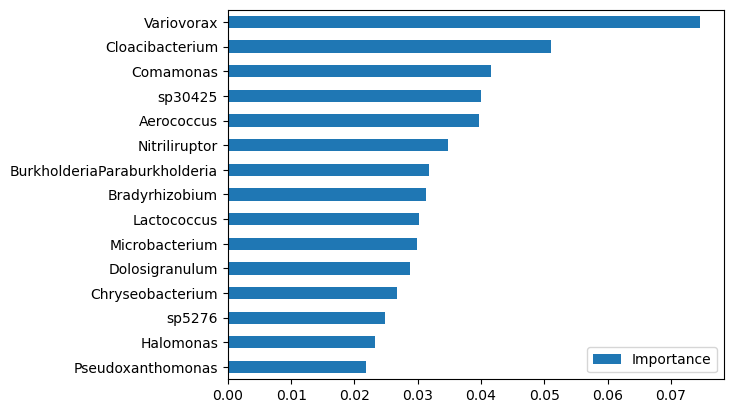

In [21]:
plot_fic = fic[:15]
plot_fic.plot(kind='barh').invert_yaxis()

In [ ]:
for estimator in xgb_scores['estimator']:
    explainerxgb = shap.Explainer(estimator, X)
    shap_valuesxgb = explainerxgb.shap_values(X)

In [23]:
np.shape(shap_valuesxgb)

(4, 61, 598)

In [24]:
shap_valuesxgb_mean = np.mean(shap_valuesxgb, axis=1)

In [25]:
np.shape(shap_valuesxgb_mean)

(4, 598)

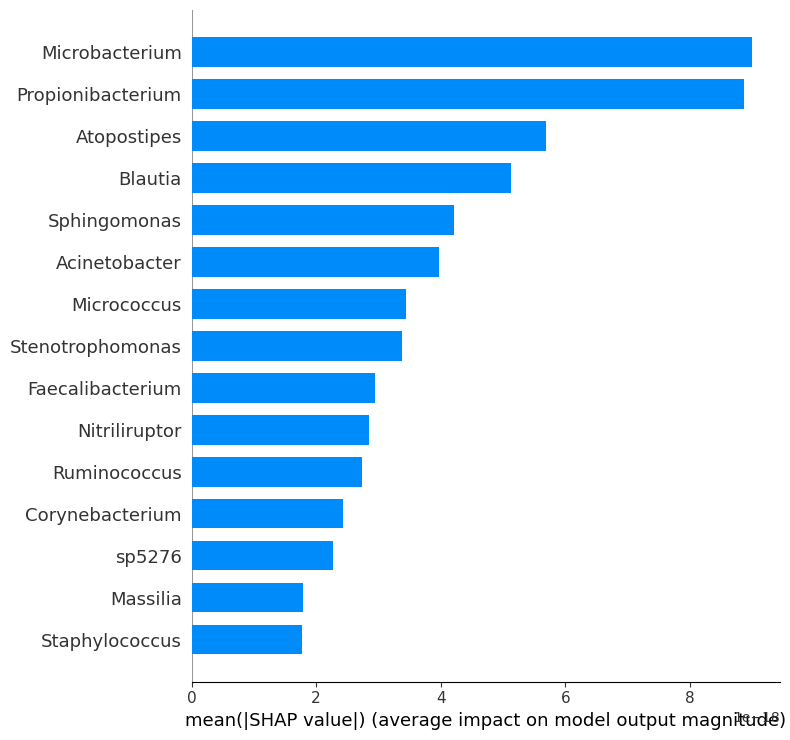

In [26]:
shap.summary_plot(shap_valuesxgb_mean, X, plot_type='bar', max_display=15)

### LightGBM

In [ ]:
clflgbm = LGBMClassifier(random_state=42)
loolgbm = LeaveOneOut()
lgbm_scores = cross_validate(clflgbm, X, y, cv=loolgbm, scoring='accuracy', return_estimator=True)

In [ ]:
lgbm_scores

In [ ]:
feature_importances_complete_lgb = []

for idx, estimator in enumerate(lgbm_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances_lgb = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances_lgb)
    feature_importances_complete_lgb.append(feature_importances_lgb)

feature_importances_complete_lgb = pd.concat(feature_importances_complete_lgb)

In [30]:
feature_importances_complete_lgb

,Importance
Corynebacterium,97
Blautia,80
Propionibacterium,78
Pseudomonas,51
Micrococcus,46
...,...
Rahnella,0
Modestobacter,0
EscherichiaShigellaSalmonella,0
Prevotella,0


In [31]:
fic_lgb = feature_importances_complete_lgb.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [32]:
fic_lgb[:15]

,Importance
Corynebacterium,89.852459
Blautia,81.852459
Propionibacterium,72.901639
Pseudomonas,51.049180
Micrococcus,46.426230
Staphylococcus,45.885246
Bacteroides,43.016393
Faecalibacterium,40.557377
Acinetobacter,37.409836
Sphingomonas,24.524590


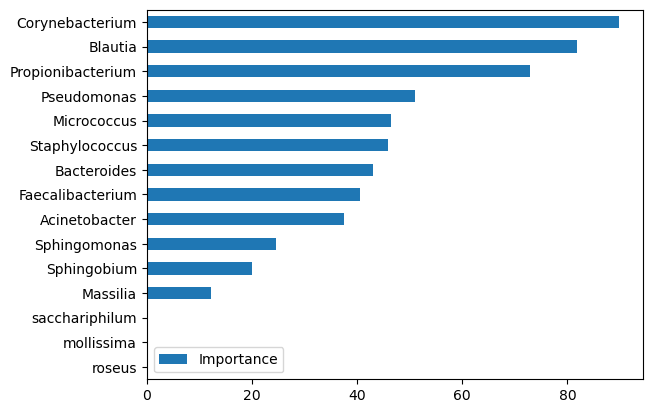

In [33]:
plot_fic_lgb = fic_lgb[:15]
plot_fic_lgb.plot(kind='barh').invert_yaxis()

In [34]:
for estimator in lgbm_scores['estimator']:
    explainerlgb = shap.Explainer(estimator, X)
    shap_valueslgb = explainerlgb.shap_values(X)    
    

In [35]:
np.shape(shap_valueslgb)

(4, 61, 598)

In [36]:
shap_valueslgb_mean = np.mean(shap_valueslgb, axis=1)

In [37]:
np.shape(shap_valueslgb_mean)

(4, 598)

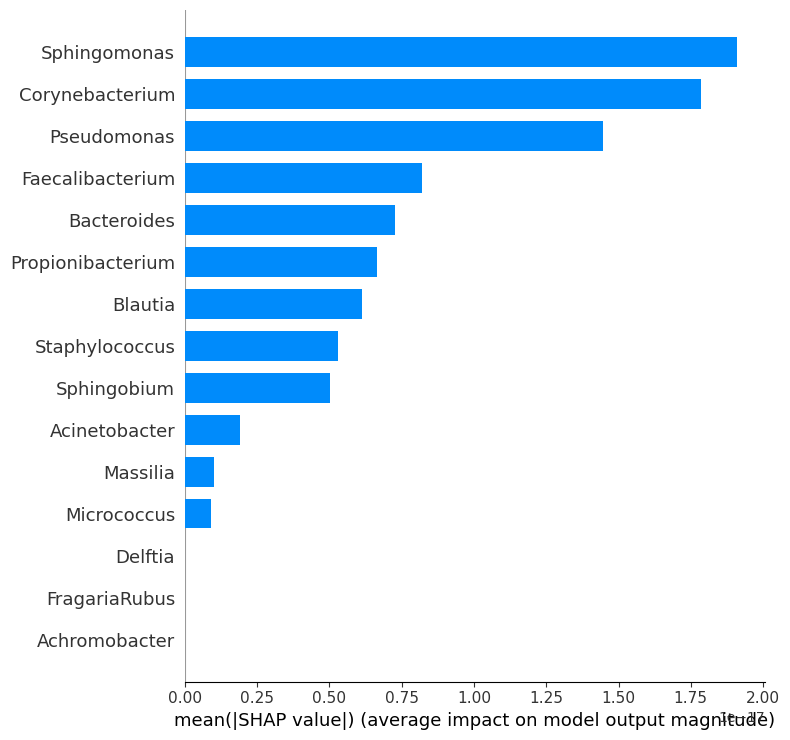

In [38]:
shap.summary_plot(shap_valueslgb_mean, X, plot_type='bar', max_display=15)

### Multilayer perceptron 

In [39]:
from sklearn.neural_network import MLPClassifier
clfmlp = MLPClassifier(solver="adam", activation="relu", learning_rate="constant", random_state=42, max_iter=30000, verbose=False)
clfmlp.out_activation_="softmax"

loomlp = LeaveOneOut()
mlp_scores = cross_validate(clfmlp, X, y, cv=loomlp, scoring='accuracy', return_estimator=True)

In [ ]:
mlp_scores

In [ ]:
# Every estimator in mlp_scores need to be fitted and permutation importance run on each estimator.
MLP_feature_importances_complete = []

for idx, estimator in enumerate(mlp_scores['estimator']):
    mlpimportance = estimator.fit(X, y)
    result = permutation_importance(mlpimportance,X, y,n_repeats=20, random_state = 42)
    MLPfeatures = pd.DataFrame(mlpimportance.feature_names_in_,columns=['Features'])
    MLPfeatures['Importance'] = result.importances_mean.tolist()
    #Sort by importance
    MLPfeatures = MLPfeatures.sort_values(by = 'Importance',ascending=False)
    print(f'The most important features for estimator {idx}:')
    print(MLPfeatures)
    MLP_feature_importances_complete.append(MLPfeatures)

MLP_feature_importances_complete = pd.concat(MLP_feature_importances_complete)

In [42]:
MLPfeatures.shape

(598, 2)

In [43]:
MLP_feature_importances_complete.shape

(36478, 2)

In [44]:
fic_mlp = MLP_feature_importances_complete.groupby('Features').mean().sort_values('Importance', ascending=False)

In [45]:
fic_mlp.shape

(598, 1)

In [46]:
fic_mlp[:15]

,Importance
Features,
sp50014,0.027869
Dolosigranulum,0.022951
sp5027,0.017213
Corynebacterium,0.011475
Acinetobacter,0.011475
Propionibacterium,0.011475
Blautia,0.008197
Moraxella,0.006557
NA,0.005738


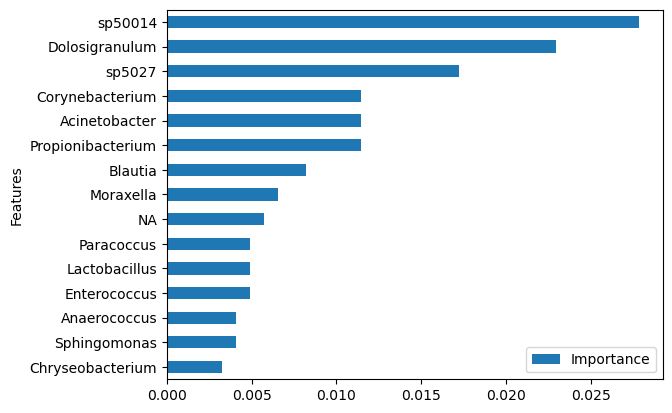

In [47]:
plot_fic_mlp = fic_mlp[:15]
plot_fic_mlp.plot(kind='barh').invert_yaxis()

In [ ]:
for estimator in mlp_scores['estimator']:
    explainermlp = shap.Explainer(mlpimportance.predict, X)
    shap_valuesmlp = explainermlp.shap_values(X)

In [49]:
np.shape(shap_valuesmlp)

(61, 598)

In [50]:
shap_valuesmlp

array([[ 4.09836066e-03,  2.18579235e-02,  3.70074342e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.56284153e-03,  2.86885246e-02,  3.96174863e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.32240437e-02, -1.91256831e-02,  1.09289617e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.36612022e-02, -2.13114754e-01,  1.77595628e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.10382514e-02,  1.36612022e-02,  2.04918033e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.09836066e-03, -7.37704918e-02, -6.69398907e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [51]:
shap_valuesmlp_mean = np.mean(shap_valuesmlp, axis=0, keepdims=True)

In [52]:
np.shape(shap_valuesmlp_mean)

(1, 598)

In [53]:
shap_valueslgb_mean

array([[ 9.10018873e-18, -1.00102076e-17, -1.13752359e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.55009436e-19, -1.00102076e-17,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.45603020e-17, -9.10018873e-19,  2.18404529e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.73209814e-17,  2.98599943e-19, -3.64007549e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

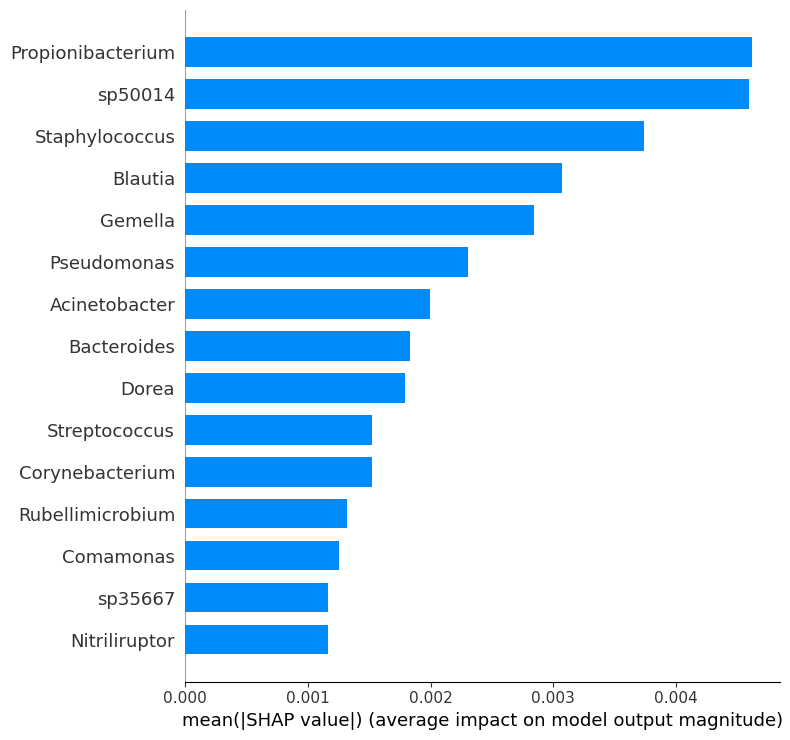

In [54]:
shap.summary_plot(shap_valuesmlp_mean, X, plot_type='bar', max_display=15)